In [1]:
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
# from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import models as M
import trainer as T

from torch.utils.tensorboard import SummaryWriter

from plot_lib import set_default


In [2]:
set_default()

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# set tensorboard "log_dir" to "logs"
writer = SummaryWriter("logs/fashion-mnist_mlp_exp2")

Using cpu device


In [4]:
DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODEL_DIR = "models"
BATCH_SIZE = 128
EPOCHS = 5

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root=DATADIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root=DATADIR,
    train=False,
    download=True,
    transform=transform,
)

In [6]:
# Create data loaders
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

for X, y in test_dataloader:
    [_, c, dx1, dx2] = X.shape
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]), torch.int64


In [7]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
writer.add_image("four_fashion_mnist_images", img_grid)

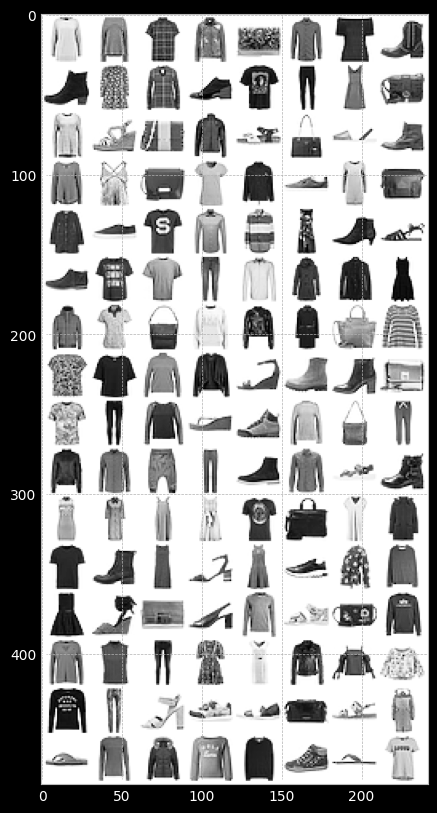

In [8]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
# show images
matplotlib_imshow(img_grid, one_channel=True)


In [9]:
# Initialize model
model = M.NeuralNetwork(c, dx1, dx2)
model = model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [11]:
# Inspect model using Tensorboard
writer.add_graph(model, images)

In [12]:
checkpoint_dir = os.path.join(MODEL_DIR, "fashion-mnist_mlp")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir, "model_temp.pth")

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")

    # Train!
    start_time = timer()
    T.train(train_dataloader, model, loss_fn, optimizer)
    end_time = timer()

    # Save model
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved PyTorch Model State to {checkpoint_path}")

    # Evaluate training and testing performance
    train_loss, train_acc = T.test(train_dataloader, model, loss_fn) # Training performance
    test_loss, test_acc = T.test(test_dataloader, model, loss_fn) # Testing performance

    print(f"Elapsed time: {end_time - start_time:.2f} seconds\n")

    # Write loss and accuracy to tensorboard
    writer.add_scalars(
        "Loss",
        {
            "train": train_loss,
            "test": test_loss,
        },
        t,
    )
    writer.add_scalars(
        "Accuracy",
        {
            "train": train_acc,
            "test": test_acc,
        },
        t,
    )

writer.flush()
writer.close() 
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 469/469 [00:03<00:00, 131.91batch/s, loss=0.304]


Saved PyTorch Model State to models/fashion-mnist_mlp/model_temp.pth
Test Performance: 
 Accuracy: 83.66%, Avg loss: 0.4673 

Test Performance: 
 Accuracy: 82.53%, Avg loss: 0.4976 

Elapsed time: 3.57 seconds

Epoch 2
-------------------------------


100%|██████████| 469/469 [00:03<00:00, 133.44batch/s, loss=0.421]


Saved PyTorch Model State to models/fashion-mnist_mlp/model_temp.pth
Test Performance: 
 Accuracy: 85.69%, Avg loss: 0.3967 

Test Performance: 
 Accuracy: 84.15%, Avg loss: 0.4393 

Elapsed time: 3.52 seconds

Epoch 3
-------------------------------


100%|██████████| 469/469 [00:03<00:00, 133.93batch/s, loss=0.425]


Saved PyTorch Model State to models/fashion-mnist_mlp/model_temp.pth
Test Performance: 
 Accuracy: 87.63%, Avg loss: 0.3392 

Test Performance: 
 Accuracy: 86.07%, Avg loss: 0.3879 

Elapsed time: 3.50 seconds

Epoch 4
-------------------------------


100%|██████████| 469/469 [00:03<00:00, 133.60batch/s, loss=0.349]


Saved PyTorch Model State to models/fashion-mnist_mlp/model_temp.pth
Test Performance: 
 Accuracy: 88.04%, Avg loss: 0.3241 

Test Performance: 
 Accuracy: 85.89%, Avg loss: 0.3770 

Elapsed time: 3.51 seconds

Epoch 5
-------------------------------


100%|██████████| 469/469 [00:03<00:00, 126.20batch/s, loss=0.269]


Saved PyTorch Model State to models/fashion-mnist_mlp/model_temp.pth
Test Performance: 
 Accuracy: 89.40%, Avg loss: 0.2910 

Test Performance: 
 Accuracy: 87.30%, Avg loss: 0.3571 

Elapsed time: 3.72 seconds

Done!
